In [11]:
import numpy as np
import pandas as pd
import pickle 
import random
import matplotlib.pyplot as plt
import joblib
from datetime import date
import requests
import datetime
import time 
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
!pip install draftfast
import draftfast

In [12]:
import keras
from keras.layers import Dense, Flatten, Reshape, Input
from keras.layers import  Dense, Lambda, dot, Activation, concatenate, LSTM, BatchNormalization, TimeDistributed
from keras.models import Sequential, Model
from keras.callbacks import History 
from keras.layers import Activation, Dropout, Flatten, Dense
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 150)


In [13]:
df_team = pd.read_csv("Team.csv")
del df_team['Unnamed: 0']
df_team['DATE'] = pd.to_datetime(df_team['DATE'])

X_features = df_team.columns.tolist()
vals_skip = ['TEAM', 'DATE']
X_features = [value for value in X_features if value not in vals_skip]

df_team_scaled = df_team[X_features]
scaler_X = MinMaxScaler()
scaler_X.fit(df_team_scaled[X_features])
df_team_scaled[X_features] = scaler_X.transform(df_team_scaled[X_features])

df_team_scaled['TEAM'] = df_team['TEAM']
df_team_scaled['DATE'] = df_team['DATE']
df_team_scaled = df_team_scaled[ ['TEAM','DATE'] + [ col for col in df_team_scaled.columns if col not in ['TEAM','DATE'] ] ]

df = pd.read_csv("Data.csv")
df['Date'] = pd.to_datetime(df['Date'])
del df['Unnamed: 0']


dd_list = []
for index, row in df.iterrows():
  try:
    mp = row['MP'].split(":")
    secs = (int(mp[0]) * 60) + int(mp[-1])
  except:
    secs = 0
  df.at[index, 'MP'] = secs
  stats = [row['PTS'], row['TRB'], row['BLK'],row['AST'],
            row['STL']]
  
  count = 0
  for stat in stats:
      if stat >= 10:
          count += 1
          
  if count == 2:
      dd_list.append(1.5)
  elif count > 2:
      dd_list.append(3)
  else:
      dd_list.append(0)

df['3P'] = .5 * df['3P']
df['ORB'] = 1.25 * df['ORB']
df['DRB'] = 1.25 * df['DRB']
df['TRB'] = 1.25 * df['TRB']
df['AST'] = 1.5 * df['AST']
df['STL'] = 2 * df['STL']
df['BLK'] = 2 * df['BLK']
df['TOV'] = -.5 * df['TOV']
df['DD_TD'] = dd_list
df['Score'] = df['3P'] + df['TRB'] + df['AST'] + df['STL'] + df['BLK'] + df['TOV'] + df['PTS'] + df['DD_TD']

from sklearn.preprocessing import MinMaxScaler

X_features = df.columns.tolist()
vals_skip = ['Player', 'Date','Team','OPP', 'Score']
X_features = [value for value in X_features if value not in vals_skip]

X_df = df[X_features]
scaler_X = MinMaxScaler()
scaler_X.fit(X_df[X_features])
X_df[X_features] = scaler_X.transform(X_df[X_features])



Y_features = ['Score']
Y_df = df[Y_features]

scaler_Y = MinMaxScaler()
scaler_Y.fit(Y_df[Y_features])
Y_df[Y_features] = scaler_Y.transform(Y_df[Y_features])

df_scaled = pd.merge(X_df, Y_df, left_index=True, right_index=True)
df_scaled = df_scaled[[ col for col in df_scaled.columns if col != 'Score' ] + ['Score'] ]
df_scaled['Player'] = df['Player']
df_scaled['Date'] = df['Date']
df_scaled = df_scaled[ ['Player','Date'] + [ col for col in df_scaled.columns if col not in ['Player','Date'] ] ]
df_scaled['Team'] = df['Team']
df_scaled['Opp'] = df['OPP']
df_scaled

,Player,Date,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,+/-,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG,ORtg,DRtg,BPM,MP,Starter,DD_TD,Score,Team,Opp
0,Al Horford,2018-10-16,0.190476,0.170732,0.571,0.000000,0.041667,0.000,0.038462,0.037037,1.0,0.000000,0.173913,0.148148,0.083333,0.000,0.4,0.727273,0.166667,0.145161,0.581633,0.403333,0.380667,0.143,0.017875,0.000,0.131,0.063,0.917273,0.000,0.117845,0.287,0.143,0.300000,0.854545,0.660670,0.461006,1.0,0.0,0.253165,BOS,PHI
1,Kyrie Irving,2018-10-16,0.095238,0.341463,0.143,0.071429,0.333333,0.125,0.076923,0.074074,1.0,0.000000,0.173913,0.148148,0.291667,0.000,0.0,0.727273,0.166667,0.112903,0.581633,0.156667,0.119333,0.571,0.017875,0.000,0.135,0.065,0.936273,0.000,0.000000,0.168,0.253,0.210000,0.870909,0.653091,0.446383,1.0,0.0,0.232911,BOS,PHI
2,Jayson Tatum,2018-10-16,0.428571,0.414634,0.529,0.071429,0.208333,0.200,0.153846,0.185185,0.8,0.166667,0.304348,0.333333,0.125000,0.125,0.0,0.909091,0.333333,0.370968,0.551020,0.399333,0.372667,0.294,0.036750,0.063,0.237,0.146,0.925818,0.016,0.000000,0.050,0.286,0.416667,0.860000,0.666733,0.445357,1.0,0.0,0.427848,BOS,PHI
3,Jaylen Brown,2018-10-16,0.238095,0.317073,0.385,0.071429,0.125000,0.333,0.038462,0.074074,0.5,0.250000,0.086957,0.185185,0.083333,0.000,0.0,0.818182,0.666667,0.193548,0.602041,0.288000,0.282000,0.231,0.019250,0.096,0.069,0.083,0.918273,0.000,0.000000,0.126,0.229,0.303333,0.870909,0.656518,0.436891,1.0,0.0,0.225316,BOS,PHI
4,Gordon Hayward,2018-10-16,0.190476,0.292683,0.333,0.071429,0.125000,0.333,0.038462,0.074074,0.5,0.166667,0.130435,0.185185,0.000000,0.500,0.0,1.000000,0.166667,0.161290,0.591837,0.258667,0.250000,0.250,0.020875,0.074,0.119,0.096,0.909091,0.075,0.000000,0.000,0.214,0.300000,0.843636,0.662778,0.378912,1.0,0.0,0.265823,BOS,PHI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54285,Patrick Williams,2021-01-05,0.238095,0.195122,0.625,0.142857,0.083333,1.000,0.076923,0.074074,1.0,0.083333,0.086957,0.111111,0.041667,0.000,0.0,0.818182,0.333333,0.225806,0.448980,0.525333,0.500000,0.250,0.031250,0.041,0.076,0.059,0.914909,0.000,0.000000,0.184,0.184,0.416667,0.916364,0.658758,0.383017,1.0,0.0,0.210127,CHI,POR
54286,Garrett Temple,2021-01-05,0.238095,0.243902,0.500,0.285714,0.375000,0.444,0.000000,0.000000,NaN,0.000000,0.043478,0.037037,0.000000,0.375,0.1,0.818182,0.166667,0.225806,0.540816,0.466667,0.466667,0.900,0.000000,0.000,0.033,0.017,0.909091,0.051,0.043771,0.167,0.178,0.343333,0.892727,0.662119,0.437404,0.0,0.0,0.260759,CHI,POR
54287,Thaddeus Young,2021-01-05,0.190476,0.195122,0.500,0.071429,0.083333,0.500,0.038462,0.037037,1.0,0.166667,0.260870,0.296296,0.166667,0.000,0.0,0.727273,0.666667,0.161290,0.510204,0.394667,0.375333,0.250,0.015625,0.088,0.243,0.169,0.932818,0.000,0.000000,0.262,0.208,0.350000,0.907273,0.656518,0.357106,0.0,0.0,0.268354,CHI,POR
54288,Denzel Valentine,2021-01-05,0.000000,0.073171,0.000,0.000000,0.083333,0.000,0.000000,0.000000,NaN,0.000000,0.347826,0.296296,0.083333,0.125,0.0,0.909091,0.000000,0.000000,0.591837,0.000000,0.000000,0.667,0.000000,0.000,0.392,0.204,0.920455,0.025,0.000000,0.250,0.088,0.106667,0.889091,0.653684,0.295536,0.0,0.0,0.162025,CHI,POR


In [14]:
for index,row in df_scaled.iterrows():
  if row['Player'] == 'Nikola Jokić':
    df_scaled.at[index, 'Player'] = 'Nikola Jokic'
    
df_scaled[df_scaled['Player'] == 'Nikola Jokic']

,Player,Date,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,+/-,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG,ORtg,DRtg,BPM,MP,Starter,DD_TD,Score,Team,Opp
251,Nikola Jokic,2018-10-17,0.285714,0.317073,0.462,0.071429,0.166667,0.250,0.307692,0.370370,0.800,0.166667,0.260870,0.296296,0.208333,0.125,0.2,0.818182,0.666667,0.338710,0.571429,0.402000,0.333333,0.308,0.096125,0.055,0.168,0.111,0.935727,0.014,0.053872,0.103,0.240,0.413333,0.885455,0.665415,0.516162,1.0,0.0,0.460759,DEN,LAC
695,Nikola Jokic,2018-10-20,0.523810,0.268293,1.000,0.214286,0.125000,1.000,0.384615,0.407407,0.909,0.000000,0.478261,0.407407,0.458333,0.500,0.1,1.000000,0.500000,0.564516,0.785714,0.736667,0.757333,0.273,0.125000,0.000,0.313,0.183,0.969636,0.061,0.046016,0.000,0.214,0.753333,0.845455,0.688283,0.472807,1.0,1.0,0.822785,DEN,PHO
806,Nikola Jokic,2018-10-21,0.333333,0.341463,0.500,0.000000,0.041667,0.000,0.346154,0.444444,0.750,0.250000,0.347826,0.407407,0.250000,0.000,0.0,0.818182,0.333333,0.370968,0.448980,0.397333,0.333333,0.071,0.107125,0.095,0.296,0.187,0.941909,0.000,0.000000,0.094,0.280,0.420000,0.898182,0.666139,0.498461,1.0,0.5,0.483544,DEN,GSW
1081,Nikola Jokic,2018-10-23,0.285714,0.268293,0.545,0.071429,0.083333,0.500,0.038462,0.037037,1.000,0.166667,0.434783,0.444444,0.250000,0.125,0.0,0.727273,0.666667,0.225806,0.673469,0.408000,0.394000,0.182,0.011375,0.092,0.479,0.281,0.938182,0.021,0.000000,0.208,0.253,0.393333,0.901818,0.662383,0.358389,1.0,0.5,0.425316,DEN,SAC
1420,Nikola Jokic,2018-10-25,0.428571,0.414634,0.529,0.071429,0.208333,0.200,0.192308,0.185185,1.000,0.250000,0.347826,0.407407,0.125000,0.125,0.1,0.454545,0.833333,0.387097,0.438776,0.416667,0.372667,0.294,0.036750,0.102,0.272,0.187,0.921273,0.014,0.025814,0.238,0.308,0.346667,0.912727,0.659549,0.505387,1.0,0.5,0.473418,DEN,LAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52904,Nikola Jokic,2020-12-28,0.380952,0.268293,0.727,0.071429,0.041667,1.000,0.076923,0.111111,0.667,0.333333,0.347826,0.444444,0.750000,0.375,0.1,0.727273,0.333333,0.306452,0.693878,0.514000,0.515333,0.091,0.034125,0.128,0.245,0.188,0.975364,0.041,0.033670,0.196,0.187,0.530000,0.890909,0.673784,0.525141,1.0,1.0,0.734177,DEN,HOU
53130,Nikola Jokic,2020-12-29,0.428571,0.341463,0.643,0.071429,0.125000,0.333,0.269231,0.259259,1.000,0.083333,0.391304,0.370370,0.500000,0.250,0.0,0.090909,0.666667,0.419355,0.500000,0.507333,0.452667,0.214,0.062500,0.039,0.255,0.164,0.950545,0.025,0.000000,0.369,0.310,0.373333,0.930909,0.661131,0.593381,1.0,1.0,0.612658,DEN,SAC
53628,Nikola Jokic,2021-01-01,0.333333,0.317073,0.538,0.214286,0.208333,0.600,0.000000,0.000000,NaN,0.250000,0.260870,0.333333,0.458333,0.125,0.0,0.909091,0.833333,0.274194,0.500000,0.436000,0.436000,0.385,0.000000,0.132,0.257,0.195,0.968000,0.018,0.000000,0.071,0.219,0.490000,0.912727,0.670489,0.454336,1.0,0.5,0.513924,DEN,PHO
53881,Nikola Jokic,2021-01-03,0.380952,0.292683,0.667,0.000000,0.041667,0.000,0.115385,0.111111,1.000,0.250000,0.391304,0.444444,0.500000,0.000,0.0,0.363636,0.833333,0.306452,0.765306,0.475333,0.444667,0.083,0.031250,0.114,0.349,0.230,0.959273,0.000,0.000000,0.344,0.265,0.400000,0.912727,0.660142,0.488199,1.0,1.0,0.536709,DEN,MIN


In [15]:
lb = 10
def format(df_scaled, lb):
  players = df_scaled['Player'].unique()
  x_list = []
  y_list = []

  for player in (players):
    df_player = df_scaled[df_scaled['Player'] == player]
    df_player.reset_index(inplace = True, drop = True)


    if len(df_player) > lb:
      for i in range(0, len(df_player) - lb):

        data = df_player.iloc[i:i+lb, :]
        y = df_player.iloc[i+lb]['Score']

        del data['Score']
        data = data.values

        team = df_player.iloc[i+lb]['Team']
        opp = df_player.iloc[i+lb]['Opp']
        date = df_player.iloc[i+lb]['Date']

        df_mid = df_team_scaled[df_team_scaled['DATE'] < date]
        df_team_vals = df_mid[df_mid['TEAM'] == team].tail(lb).values
        df_opp_vals = df_mid[df_mid['TEAM'] == opp].tail(lb).values

        if df_team_vals.shape[0]!= lb or df_opp_vals.shape[0] != lb:
          pass
        else:
          final_array = np.hstack((data[:,2:39],df_team_vals[:,2:],df_opp_vals[:,2:]))
          x_list.append(final_array)
          y_list.append(y)

  x = np.stack(x_list)
  y = np.asarray(y_list, dtype=np.float32)
  x = np.asarray(x).astype('float32')
  y = np.asarray(y).astype('float32')
  x[np.isnan(x)] = 0
  y[np.isnan(y)] = 0

  return x,y
  
split = int(len(df_scaled) * .9)
_tail = len(df_scaled) - split
x_train, y_train = format(df_scaled.head(split), lb) 
x_test, y_test = format(df_scaled.tail(_tail), lb)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((42767, 10, 69), (42767,), (1761, 10, 69), (1761,))

In [16]:
def attention_3d_block(hidden_states):

    hidden_size = int(hidden_states.shape[2])
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)

    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)

    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(16, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)

    return attention_vector

history = History()
model = Sequential()

inp = Input(x_train[0].shape)
x = (LSTM(8, return_sequences=True))(inp)
x = (Dropout(.05))(x)
x = (BatchNormalization())(x)
x = (LSTM(16, return_sequences=True))(x)
x = (Dropout(.05))(x)
x = (LSTM(8, return_sequences=True))(x)
x = (Dropout(.05))(x)
attention_output = (attention_3d_block(x))
out = (Dense(1, activation = 'relu'))(attention_output)

model = Model(inputs = inp, outputs = out)
model.compile(
  optimizer='adam',
  loss='mean_squared_error'
)

model.summary()

model.fit(x_train, y_train,
          batch_size=100,
          epochs=10,
          verbose=1,
          shuffle = True,
          validation_data=(x_test, y_test),
          callbacks=[history])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 69)]     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 10, 8)        2496        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 10, 8)        0           lstm_3[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 10, 8)        32          dropout_3[0][0]                  
____________________________________________________________________________________________

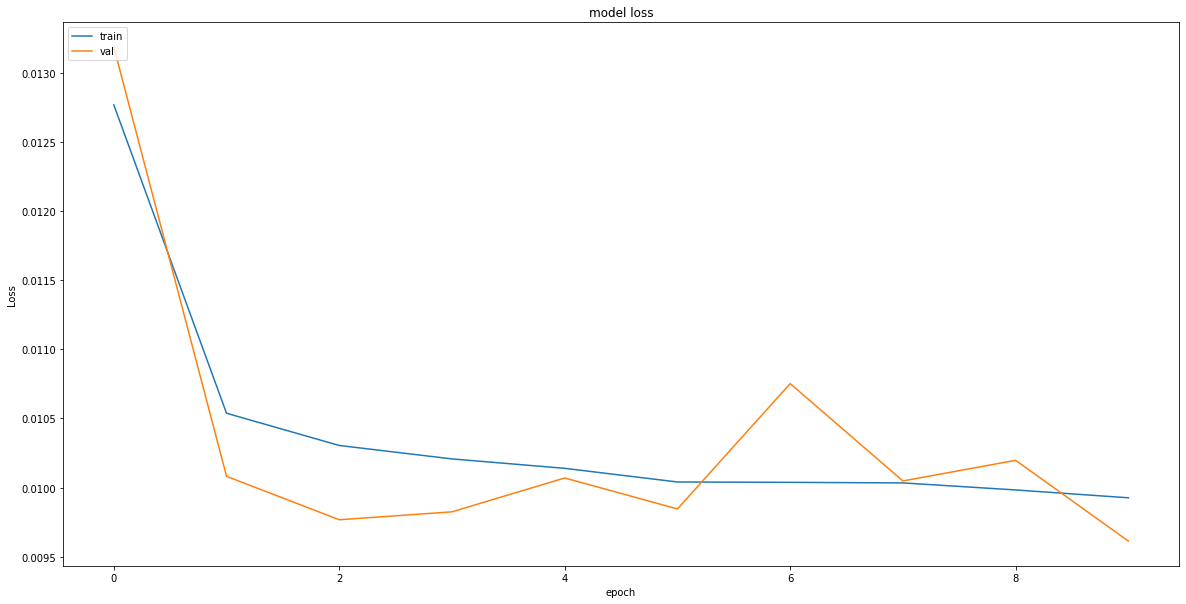

56/56 [==============================] - 0s 4ms/step - loss: 0.0096


0.009613143280148506

In [17]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot()

x = np.arange(0,len(history.history['loss']))

ax.plot(x,history.history['loss'])
ax.plot(x,history.history['val_loss'])


plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
model.evaluate(x_test, y_test)

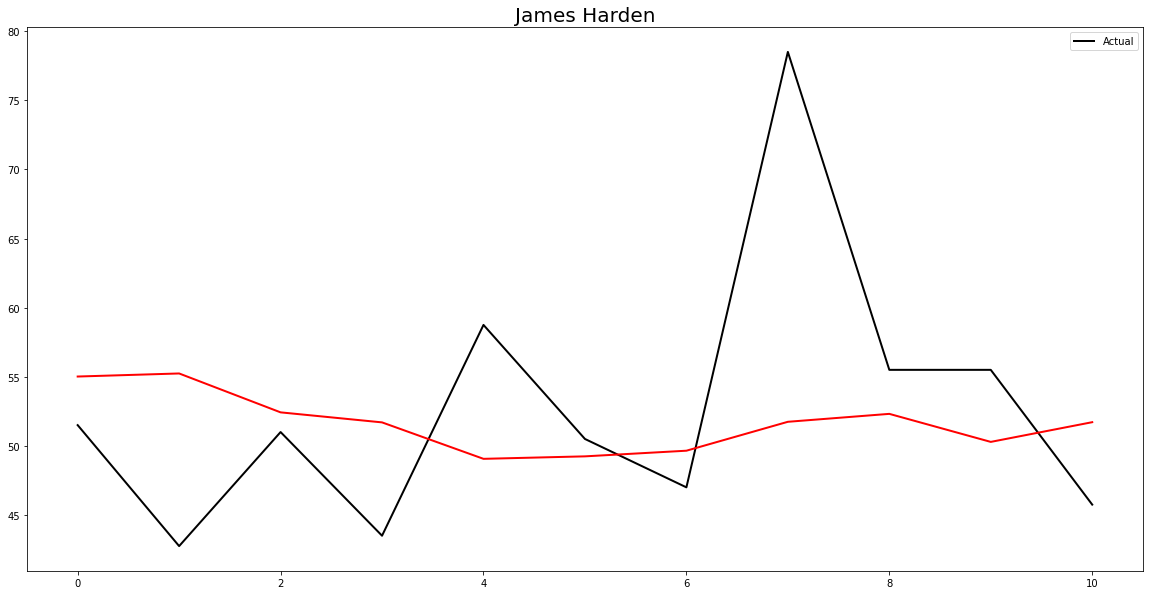

In [18]:
player = "James Harden"
df_test = df_scaled.tail(_tail)
df_player = df_test[df_test['Player'] == player]
x_array, y_array = format(df_player, lb)

actual = scaler_Y.inverse_transform((y_array.reshape(-1,1)))
x_array = np.asarray(x_array).astype('float32')
x_array[np.isnan(x_array)] = 0

_preds = model.predict(x_array)
preds = scaler_Y.inverse_transform(_preds)

fig = plt.figure(figsize=(20,10))
ax = plt.subplot()

co = 10
ax.plot(actual, label = 'Actual', color = 'black', linewidth = 2)
ax.plot(preds, color = 'red', linewidth = 2)
plt.title(player, fontsize = 20)
ax.legend()

In [20]:
def format_current(df_scaled, df_team_scaled, team, opp, date, lb):
  players = df_scaled['Player'].unique()
  x_list = []
  y_list = []

  for player in (players):
    df_player = df_scaled[df_scaled['Player'] == player]
    df_player.reset_index(inplace = True, drop = True)

    
    if len(df_player) > lb:
      
        data = df_player.tail(lb)
        del data['Score']
        data = data.values

        #team = df_player.iloc[i+5]['Team']
        #opp = df_player.iloc[i+5]['Opp']
        #date = df_player.iloc[i+5]['Date']

        df_mid = df_team_scaled[df_team_scaled['DATE'] < date]
        df_team_vals = df_mid[df_mid['TEAM'] == team].tail(lb).values
        df_opp_vals = df_mid[df_mid['TEAM'] == opp].tail(lb).values

        if df_team_vals.shape[0]!= lb or df_opp_vals.shape[0] != lb:
          return None
        else:
          final_array = np.hstack((data[:,2:39],df_team_vals[:,2:],df_opp_vals[:,2:]))
          x_list.append(final_array)

    else:
      return None
    
  x = np.asarray(x_list)
  x = np.asarray(x).astype('float32')
  x[np.isnan(x)] = 0
  return x

def prediciton_func(df_scaled, team, opp, date, lb):
  
  url_team = "https://www.basketball-reference.com/teams/{}/2021.html".format(team)
  html_text = requests.get(url_team).text
  team_soup = bs(html_text)

  table = team_soup.find_all('table', id = 'roster')
  df_team = pd.read_html(str(table))[0]
  home_players = df_team['Player']
  home_players = list(home_players.values)

  df_mid = df_scaled[df_scaled['Player'].isin(home_players)]

  pred_list = []
  for player in home_players:
    df_mid_player = df_mid[df_mid['Player'] == player]
    x = format_current(df_mid_player, df_team_scaled, team, opp, date, lb)
    if x is not None and x != []:
      prediction = model.predict(x)
      prediction = scaler_Y.inverse_transform(prediction)
      pred_list.append(prediction[0][0])
    else:
      pred_list.append(0)

  return home_players, pred_list

url = "https://www.basketball-reference.com/leagues/NBA_2021_games-january.html"
html_text = requests.get(url).text
games = bs(html_text)

table_rows = games.find_all('tr')
l = []
df_list = []
for tr in (table_rows[1:]):
    td = list(tr.find_all('td'))
    home = td[1].get("csk")
    away = td[3].get("csk")

    if home[4:12] == "20210106":
      home_team = home[0:3]
      away_team = away[0:3]
      
      home_players, home_preds = prediciton_func(df_scaled, home_team, away_team,'2020-01-05', lb)
      away_players, away_preds = prediciton_func(df_scaled, away_team, home_team,'2020-01-05', lb)
          
      df_mid = pd.DataFrame(home_players)
      df_mid['Preds'] = home_preds

      df_mid_away = pd.DataFrame(away_players)
      df_mid_away['Preds'] = away_preds

      df_concat = pd.concat([df_mid, df_mid_away])
      df_list.append(df_concat)
    
    else:
      pass

df_final = pd.concat(df_list)
df_final.columns = ['Player', 'Preds']
df_final.head(10)

,Player,Preds
0,Christian Wood,40.207306
1,Sterling Brown,11.446399
2,Jae'Sean Tate,0.000000
3,P.J. Tucker,16.415781
4,James Harden,48.613541
5,David Nwaba,15.354262
6,Danuel House,19.894533
7,John Wall,40.867466
8,Eric Gordon,24.544785
9,DeMarcus Cousins,13.047201


In [37]:
from draftfast import rules
from draftfast.optimize import run
from draftfast.csv_parse import salary_download
from draftfast.rules import DRAFT_KINGS
from draftfast.lineup_constraints import LineupConstraints
from draftfast.orm import Player
from draftfast.optimize import run_multi

dk = pd.read_csv("DKSalaries.csv")
dk = pd.concat([dk.set_index('Name'),df_final.set_index('Player')], axis=1, join='inner')
del dk['AvgPointsPerGame']
dk.index = dk.index.set_names(['Name'])
dk.reset_index(inplace = True)
dk.columns = [*dk.columns[:-1], 'AvgPointsPerGame']

dk.to_csv("DKSalaries_new.csv")

player_pool = salary_download.generate_players_from_csvs(
  salary_file_location='DKSalaries_new.csv',
  game=DRAFT_KINGS,
)

constraints=LineupConstraints(
    #locked=['Caris LeVert'],
    banned=['Jonathan Isaac','Klay Thompson','Matthew Dellavedova','Malik Monk','Cody Zeller','Rajon Rondo',
            'Tony Snell','Jabari Parker','Marquese Chriss','Trevor Ariza','Cody Martin','Kemba Walker','Patrick McCaw',
            'Kevin Love','Kent Bazemore','T.J. Warren']
    #groups=[
    #    [('Kemba Walker', 'Stephen Curry'), (1)],
    #]
)

roster = run_multi(
    iterations=1,
    rule_set=rules.DK_NBA_RULE_SET,
    player_pool=player_pool,
    constraints=constraints,
    verbose=True

  )
roster

Optimal roster for: NBA
+------------+-----------------+------+-------------------------------+--------+--------------------+----------+--------+
| Position   | Player          | Team | Matchup                       | Salary |         Projection | vs. Avg. | Locked |
+------------+-----------------+------+-------------------------------+--------+--------------------+----------+--------+
| PG         | John Wall       | HOU  | HOU@IND 01/06/2021 07:00PM ET |   7400 |  40.86746597290039 |     0.00 |        |
| PG         | Devonte' Graham | CHA  | CHA@ATL 01/06/2021 07:30PM ET |   5500 | 27.818193435668945 |     0.00 |        |
| PG/SG (SG) | Coby White      | CHI  | CHI@SAC 01/06/2021 10:00PM ET |   6800 | 35.514286041259766 |     0.00 |        |
| PG/SF (SF) | Jimmy Butler    | MIA  | BOS@MIA 01/06/2021 07:30PM ET |   7300 |  37.39641571044922 |     0.00 |        |
| PF         | Thaddeus Young  | CHI  | CHI@SAC 01/06/2021 10:00PM ET |   4600 |  24.32512092590332 |     0.00 |        |


([+------------+-----------------+------+-------------------------------+--------+--------------------+----------+--------+
  | Position   | Player          | Team | Matchup                       | Salary |         Projection | vs. Avg. | Locked |
  +------------+-----------------+------+-------------------------------+--------+--------------------+----------+--------+
  | PG         | John Wall       | HOU  | HOU@IND 01/06/2021 07:00PM ET |   7400 |  40.86746597290039 |     0.00 |        |
  | PG         | Devonte' Graham | CHA  | CHA@ATL 01/06/2021 07:30PM ET |   5500 | 27.818193435668945 |     0.00 |        |
  | PG/SG (SG) | Coby White      | CHI  | CHI@SAC 01/06/2021 10:00PM ET |   6800 | 35.514286041259766 |     0.00 |        |
  | PG/SF (SF) | Jimmy Butler    | MIA  | BOS@MIA 01/06/2021 07:30PM ET |   7300 |  37.39641571044922 |     0.00 |        |
  | PF         | Thaddeus Young  | CHI  | CHI@SAC 01/06/2021 10:00PM ET |   4600 |  24.32512092590332 |     0.00 |        |
  | PF/C

In [28]:
df_scaled[df_scaled['Player'] == 'Jabari Parker']

,Player,Date,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,+/-,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG,ORtg,DRtg,BPM,MP,Starter,DD_TD,Score,Team,Opp
301,Jabari Parker,2018-10-18,0.333333,0.390244,0.438,0.071429,0.166667,0.250,0.000000,0.000000,NaN,0.083333,0.173913,0.185185,0.041667,0.125,0.0,0.818182,0.500000,0.241935,0.346939,0.312667,0.312667,0.250,0.000000,0.039,0.169,0.101,0.914727,0.018,0.000000,0.111,0.290,0.273333,0.921818,0.654475,0.387891,0.0,0.0,0.260759,CHI,PHI
641,Jabari Parker,2018-10-20,0.238095,0.317073,0.385,0.142857,0.125000,0.667,0.038462,0.074074,0.500,0.166667,0.173913,0.222222,0.041667,0.000,0.0,1.000000,0.500000,0.209677,0.418367,0.312000,0.308000,0.231,0.019250,0.113,0.150,0.135,0.914545,0.000,0.000000,0.000,0.257,0.343333,0.929091,0.655331,0.364802,0.0,0.0,0.248101,CHI,DET
948,Jabari Parker,2018-10-22,0.380952,0.341463,0.571,0.142857,0.125000,0.667,0.076923,0.111111,0.667,0.166667,0.043478,0.111111,0.041667,0.125,0.0,0.909091,0.333333,0.322581,0.377551,0.435333,0.428667,0.214,0.026750,0.114,0.050,0.080,0.916364,0.020,0.000000,0.061,0.301,0.430000,0.927273,0.662778,0.369933,0.0,0.0,0.296203,CHI,DAL
1199,Jabari Parker,2018-10-24,0.142857,0.170732,0.429,0.000000,0.083333,0.000,0.192308,0.185185,1.000,0.000000,0.391304,0.333333,0.166667,0.250,0.0,0.727273,0.000000,0.177419,0.581633,0.398667,0.286000,0.286,0.089250,0.000,0.320,0.174,0.926727,0.033,0.000000,0.246,0.179,0.353333,0.909091,0.660274,0.472037,0.0,0.0,0.326582,CHI,CHO
1447,Jabari Parker,2018-10-26,0.333333,0.341463,0.500,0.142857,0.208333,0.400,0.115385,0.111111,1.000,0.166667,0.000000,0.074074,0.041667,0.000,0.1,0.727273,0.166667,0.306452,0.306122,0.413333,0.380667,0.357,0.026750,0.080,0.000,0.044,0.916182,0.000,0.034792,0.164,0.318,0.353333,0.970909,0.655727,0.395331,0.0,0.0,0.263291,CHI,CHO
1649,Jabari Parker,2018-10-27,0.333333,0.390244,0.438,0.214286,0.250000,0.500,0.038462,0.074074,0.500,0.166667,0.260870,0.296296,0.125000,0.125,0.2,0.727273,0.166667,0.290323,0.571429,0.355333,0.354000,0.375,0.015625,0.063,0.154,0.113,0.923818,0.014,0.071829,0.151,0.254,0.316667,0.863636,0.660340,0.524885,0.0,0.0,0.405063,CHI,ATL
1975,Jabari Parker,2018-10-29,0.333333,0.365854,0.467,0.000000,0.125000,0.000,0.038462,0.185185,0.200,0.166667,0.304348,0.333333,0.208333,0.125,0.1,0.909091,0.000000,0.241935,0.479592,0.290667,0.311333,0.200,0.041625,0.069,0.319,0.176,0.934000,0.017,0.040404,0.055,0.281,0.336667,0.958182,0.658033,0.405849,0.0,0.0,0.392405,CHI,GSW
2273,Jabari Parker,2018-10-31,0.142857,0.243902,0.300,0.000000,0.166667,0.000,0.000000,0.037037,0.000,0.000000,0.391304,0.333333,0.000000,0.000,0.0,0.909091,0.666667,0.096774,0.459184,0.191333,0.200000,0.400,0.012500,0.000,0.268,0.135,0.909091,0.000,0.000000,0.087,0.151,0.176667,0.900000,0.649268,0.547973,1.0,0.0,0.184810,CHI,DEN
2575,Jabari Parker,2018-11-02,0.238095,0.292683,0.417,0.000000,0.041667,0.000,0.038462,0.037037,1.000,0.083333,0.260870,0.259259,0.083333,0.000,0.0,0.636364,0.000000,0.177419,0.428571,0.294667,0.278000,0.083,0.010375,0.037,0.236,0.133,0.917727,0.000,0.000000,0.243,0.248,0.246667,0.918182,0.651180,0.458697,1.0,0.0,0.225316,CHI,IND
2787,Jabari Parker,2018-11-03,0.285714,0.292683,0.500,0.071429,0.125000,0.333,0.076923,0.074074,1.000,0.000000,0.130435,0.111111,0.000000,0.125,0.0,0.363636,0.333333,0.241935,0.520408,0.388000,0.361333,0.250,0.020875,0.000,0.083,0.043,0.909091,0.012,0.000000,0.352,0.232,0.230000,0.901818,0.652564,0.621601,1.0,0.0,0.194937,CHI,HOU
